In [17]:
import os
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import LearningRateMonitor
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from omegaconf import OmegaConf
import torchmetrics

# Imports of own files
import model_factory
import dataset_factory

from glob import glob
import os.path as osp

In [2]:
exprement_number = '3cq6cxoy'
folder_name = 'DGCNN'
path_files = glob(osp.join(folder_name,exprement_number,'checkpoints','*'))
path_file = path_files[0]
print(path_file)


DGCNN/3cq6cxoy/checkpoints/epoch=499-step=101499.ckpt


In [3]:
class Runner(pl.LightningModule):
    def __init__(self, cfg, model):
        super().__init__()
        self.cfg = cfg
        self.model = model
        self.loss_fn = nn.NLLLoss()

        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.test_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        # Runner needs to redirect any model.forward() calls to the actual
        # network
        return self.model(x)

    def configure_optimizers(self):
        if self.cfg.optimize.optimizer == 'Adam':
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.optimize.lr)
        else:
            raise NotImplementedError(f"Optimizer {self.cfg.optimizer}")
        
        if self.cfg.optimize.lr_scheduler == 'None':
            return optimizer
        elif self.cfg.optimize.lr_scheduler == 'CosineAnnealingLR':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.cfg.optimize.T_max)
        elif self.cfg.optimize.lr_scheduler == 'CosineAnnealingWarmRestarts':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=self.cfg.optimize.T_0)
        elif self.cfg.optimize.lr_scheduler == 'ReduceLROnPlateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=self.cfg.optimize.mode, factor=self.cfg.optimize.factor, patience=self.cfg.optimize.patience) 
        else:
            raise NotImplementedError(f"Scheduler {self.cfg.optimize.lr_scheduler}")
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss_step",
                "frequency": 1
                # If "monitor" references validation metrics, then "frequency" should be set to a
                # multiple of "trainer.check_val_every_n_epoch".
            },
        }

    def _step(self, batch):
        y = batch.y
        y_hat = self.model(batch)
        loss = self.loss_fn(y_hat, y)
        return loss, y_hat

    def training_step(self, batch, batch_idx):
        loss, y_hat = self._step(batch)
        preds = torch.argmax(y_hat, dim=1)
        self.train_accuracy(preds, batch.y)

        # Log step-level loss & accuracy
        self.log("train/loss_step", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train/acc_step", self.train_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        # return loss

    def validation_step(self, batch, batch_idx):
        loss, y_hat = self._step(batch)
        preds = torch.argmax(y_hat, dim=1)
        self.val_accuracy(preds, batch.y)

        # Log step-level loss & accuracy
        self.log("val/loss_step", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val/acc_step", self.val_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        # return loss

    def test_step(self, batch, batch_idx):
        loss, y_hat = self._step(batch)
        preds = torch.argmax(y_hat, dim=1)
        self.test_accuracy(preds, batch.y)

        # Log test loss
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test/acc', self.test_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

In [14]:
# Load defaults and overwrite by command-line arguments
cfg = OmegaConf.load("config.yaml")


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create datasets using factory pattern
loaders = dataset_factory.factory(cfg)
train_dataset_loader, val_dataset_loader, test_dataset_loader = loaders


# Create model using factory pattern
model = model_factory.factory(cfg)

# Tie it all together with PyTorch Lightning: Runner contains the model,
# optimizer, loss function and metrics; Trainer executes the
# training/validation loops and model checkpointing.
model = Runner.load_from_checkpoint(path_file,cfg=cfg, model=model).to(device)

Using device: cuda


In [15]:
def test(loader, model):
    model.eval()
    all_pred = []
    all_true = []
    correct = 0
    total_loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            pred = out.max(dim=1)[1]
            all_pred.append(pred)
            all_true.append(data.y)
            loss = F.nll_loss(out, data.y)
            correct += pred.eq(data.y).sum().item()
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset), correct / len(loader.dataset), all_pred, all_true


In [19]:
test_loss, test_acc, all_pred, all_true = test(test_dataset_loader, model)

In [20]:
print(test_loss, test_acc)

2.2556969297768004 0.5129151291512916


In [9]:
class_names = []
for cc in range(101):
    idx = np.where(test_dataset.data.y == cc)[0][0]   
    class_names.append(test_dataset.data.label[idx][0])
    print(test_dataset.data.y[idx].item(), test_dataset.data.label[idx][0])

0 BACKGROUND_Google
1 Faces_easy
2 Leopards
3 Motorbikes
4 accordion
5 airplanes
6 anchor
7 ant
8 barrel
9 bass
10 beaver
11 binocular
12 bonsai
13 brain
14 brontosaurus
15 buddha
16 butterfly
17 camera
18 cannon
19 car_side
20 ceiling_fan
21 cellphone
22 chair
23 chandelier
24 cougar_body
25 cougar_face
26 crab
27 crayfish
28 crocodile
29 crocodile_head
30 cup
31 dalmatian
32 dollar_bill
33 dolphin
34 dragonfly
35 electric_guitar
36 elephant
37 emu
38 euphonium
39 ewer
40 ferry
41 flamingo
42 flamingo_head
43 garfield
44 gerenuk
45 gramophone
46 grand_piano
47 hawksbill
48 headphone
49 hedgehog
50 helicopter
51 ibis
52 inline_skate
53 joshua_tree
54 kangaroo
55 ketch
56 lamp
57 laptop
58 llama
59 lobster
60 lotus
61 mandolin
62 mayfly
63 menorah
64 metronome
65 minaret
66 nautilus
67 octopus
68 okapi
69 pagoda
70 panda
71 pigeon
72 pizza
73 platypus
74 pyramid
75 revolver
76 rhino
77 rooster
78 saxophone
79 schooner
80 scissors
81 scorpion
82 sea_horse
83 snoopy
84 soccer_ball
85 stap

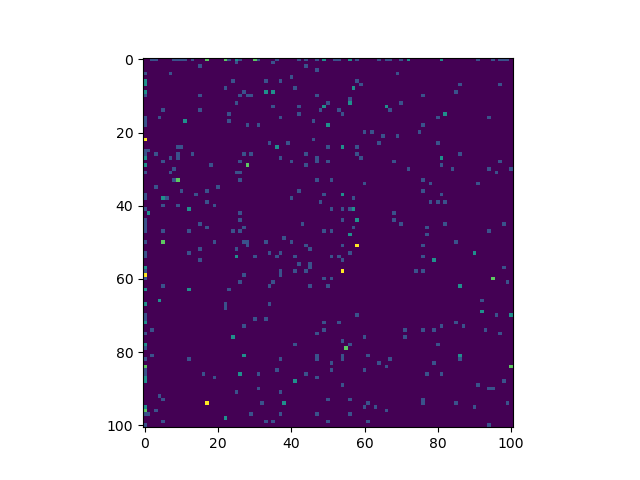

In [10]:
%matplotlib widget

y_true = torch.cat(all_true,dim=0).cpu().numpy()
y_pred = torch.cat(all_pred,dim=0).cpu().numpy()

conf_mat = confusion_matrix(y_true, y_pred)
np.fill_diagonal(conf_mat, 0)
# plt.figure(figsize=(10,10))
plt.imshow(conf_mat, interpolation='none')
plt.show()

In [11]:
max_number = 20
rows_sorted, columns_sorted = np.unravel_index(np.argsort(conf_mat.flatten())[::-1][:max_number], conf_mat.shape)
for r,c in zip(rows_sorted,columns_sorted):
    print(conf_mat[r,c],class_names[r],r,class_names[c],c)

4 chair 22 BACKGROUND_Google 0
4 lobster 59 BACKGROUND_Google 0
4 watch 94 camera 17
4 llama 58 kangaroo 54
4 ibis 51 llama 58
3 crocodile_head 29 crocodile 28
3 helicopter 50 airplanes 5
3 lotus 60 water_lilly 95
3 BACKGROUND_Google 0 cup 30
3 dolphin 33 bass 9
3 soccer_ball 84 yin_yang 100
3 BACKGROUND_Google 0 chair 22
3 BACKGROUND_Google 0 camera 17
3 schooner 79 ketch 55
3 wheelchair 96 BACKGROUND_Google 0
3 soccer_ball 84 BACKGROUND_Google 0
2 stop_sign 88 BACKGROUND_Google 0
2 buddha 15 sea_horse 82
2 bass 9 electric_guitar 35
2 pizza 72 BACKGROUND_Google 0


In [12]:
%matplotlib widget
max_number = 20
num_classses = [torch.sum(test_dataset.data.y == i).item() for i in np.arange(101)]
num_errors = np.sum(conf_mat,axis=1)
sorted_vec = num_errors/num_classses
# plt.stem(err_vec,linefmt = 'r:',markerfmt='rD')
for ii in sorted_vec.argsort()[::-1][:max_number]:
    print(ii,num_errors[ii],num_classses[ii],num_errors[ii]/num_classses[ii])
plt.show()

62 6 6 1.0
97 6 6 1.0
44 6 6 1.0
10 7 7 1.0
24 8 8 1.0
29 8 8 1.0
9 8 9 0.8888888888888888
28 7 8 0.875
6 6 7 0.8571428571428571
59 6 7 0.8571428571428571
18 6 7 0.8571428571428571
58 10 12 0.8333333333333334
78 5 6 0.8333333333333334
99 5 6 0.8333333333333334
95 5 6 0.8333333333333334
70 5 6 0.8333333333333334
27 9 11 0.8181818181818182
26 9 11 0.8181818181818182
33 8 10 0.8
82 7 9 0.7777777777777778


In [13]:
for ii in np.where(np.diag(confusion_matrix(y_true, y_pred)) == 0)[0]:
    print(ii,class_names[ii])

10 beaver
24 cougar_body
29 crocodile_head
44 gerenuk
62 mayfly
97 wild_cat
